In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import seaborn as sns
import sys
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install shutil
!{sys.executable} -m pip install split-folders

import splitfolders

import os
from shutil import unpack_archive
from shutil import rmtree
pd.set_option("display.max_columns", 101)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=7c7dc32fde9eb38d94182d16e3a41ebe329978e8ad092a149af74b70a80d5f09
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download dan extract dataset

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ" -O dataset.zip && rm -rf /tmp/cookies.txt

unpack_archive('dataset.zip', '')

os.remove('dataset.zip')

--2023-05-13 22:12:43--  https://docs.google.com/uc?export=download&confirm=t&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ
Resolving docs.google.com (docs.google.com)... 108.177.119.101, 108.177.119.100, 108.177.119.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pdkt9s56p1dosjtl68frur0e22aqfrjm/1684015950000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=067c1a36-c94e-482c-98e8-53800f70b8f4 [following]
--2023-05-13 22:12:43--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pdkt9s56p1dosjtl68frur0e22aqfrjm/1684015950000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=067c1a36-c94e-482c-98e8-53800f70b8f4
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 108.177.127.

In [3]:
# split validation folder to validation and test with ratio 6:4

output = "split-folders"
splitfolders.ratio("validation", output=output, ratio=(.8,.2))

os.chdir('split-folders')
os.rename('train','validation')
os.rename('val','test')

os.chdir('/content')
rmtree('validation')

Copying files: 7066 files [00:00, 9797.93 files/s]


In [4]:
# get label
labels = os.listdir('train')
print(labels)

['angry', 'disgust', 'neutral', 'happy', 'surprise', 'fear', 'sad']


In [5]:
data_labels = []
for label in labels:
    total = len(os.listdir(os.path.join('train', label)))
    detail_labels = [label, total]
    data_labels.append(detail_labels)

print(data_labels)

[['angry', 3993], ['disgust', 436], ['neutral', 4982], ['happy', 7164], ['surprise', 3205], ['fear', 4103], ['sad', 4938]]


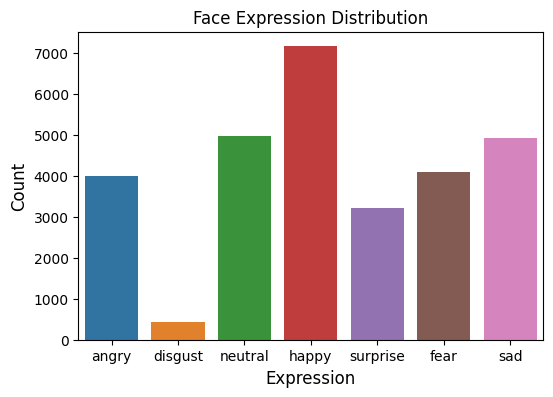

In [6]:
df_labels = pd.DataFrame(data_labels)
df_labels.columns = ['Expression', 'Count']
plt.figure(figsize=(6,4))
sns.barplot(df_labels, x='Expression', y='Count')
plt.title('Face Expression Distribution')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Expression', fontsize=12)
plt.show()

In [7]:
# Total of training data

total_training = 0
total_validation = 0 
total_testing = 0
for label in labels:
    total_train = len(os.listdir(os.path.join('train', label)))
    total_val = len(os.listdir(os.path.join('split-folders/validation', label)))
    total_test = len(os.listdir(os.path.join('split-folders/test', label)))
    total_training += total_train
    total_validation += total_val
    total_testing += total_test

print('the amount of training data is', total_training)
print('the amount of validation data is', total_validation)
print('the amount of testing data is', total_testing)

the amount of training data is 28821
the amount of validation data is 5650
the amount of testing data is 1416


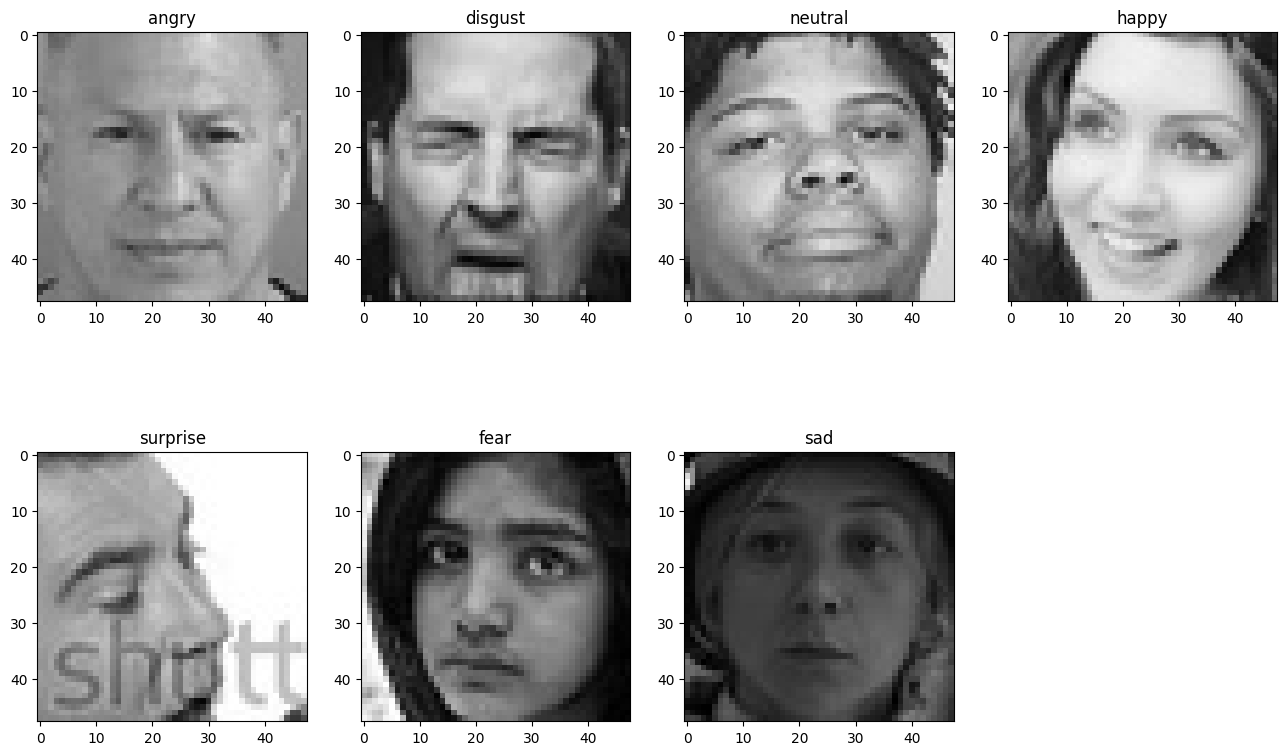

In [8]:
def FaceImage(face_image, expression, path):
    image_dir = os.path.join(path, expression)
    image_path = os.path.join(image_dir, face_image)
    img = mpimg.imread(image_path)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), expression], dtype=object)

plt.figure(0, figsize=(16,10))
i = 1;
for label in labels:
    image_dir = os.path.join('train', label)
    image_list = os.listdir(image_dir)
    face_image = image_list[0]
    img = FaceImage(face_image, label, 'train')
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])
    i+=1

plt.show()  

In [10]:
#initilize parameters
epochs = 100
batch_size = 64

In [11]:
# Image Data Generator
train_datagen = ImageDataGenerator(
      rotation_range = 10,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator()

In [12]:
# Image Data Preprocess

train_generator = train_datagen.flow_from_directory(
    "train/",
    target_size=(48,48),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "split-folders/validation/",
    target_size=(48,48),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

Found 28821 images belonging to 7 classes.
Found 5650 images belonging to 7 classes.


In [13]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(532, (3,3), activation='relu', padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [14]:
# Compile model

model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics = ["accuracy"])

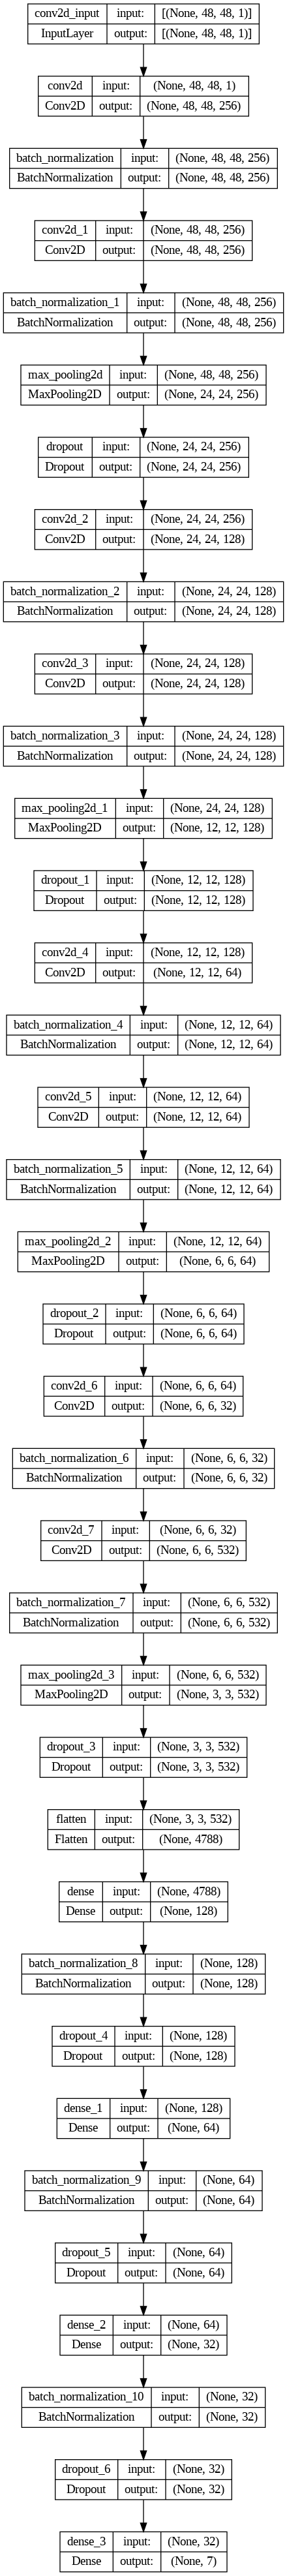

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [15]:
# Fit model

history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=epochs, 
    steps_per_epoch = total_training/batch_size,
    validation_steps = total_validation/batch_size,
    verbose = 1,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
)

Epoch 1/100
450/450 [==============================] - 85s 140ms/step - loss: 1.9701 - accuracy: 0.2300 - val_loss: 1.7077 - val_accuracy: 0.3108
Epoch 2/100
450/450 [==============================] - 60s 134ms/step - loss: 1.7176 - accuracy: 0.3130 - val_loss: 1.5722 - val_accuracy: 0.3878
Epoch 3/100
450/450 [==============================] - 60s 134ms/step - loss: 1.5002 - accuracy: 0.4171 - val_loss: 1.6216 - val_accuracy: 0.3873
Epoch 4/100
450/450 [==============================] - 60s 134ms/step - loss: 1.3900 - accuracy: 0.4637 - val_loss: 1.5064 - val_accuracy: 0.4062
Epoch 5/100
450/450 [==============================] - 66s 147ms/step - loss: 1.3206 - accuracy: 0.4955 - val_loss: 1.3566 - val_accuracy: 0.4860
Epoch 6/100
450/450 [==============================] - 61s 136ms/step - loss: 1.2699 - accuracy: 0.5186 - val_loss: 1.1796 - val_accuracy: 0.5427
Epoch 7/100
450/450 [==============================] - 66s 147ms/step - loss: 1.2348 - accuracy: 0.5342 - val_loss: 1.2013 -

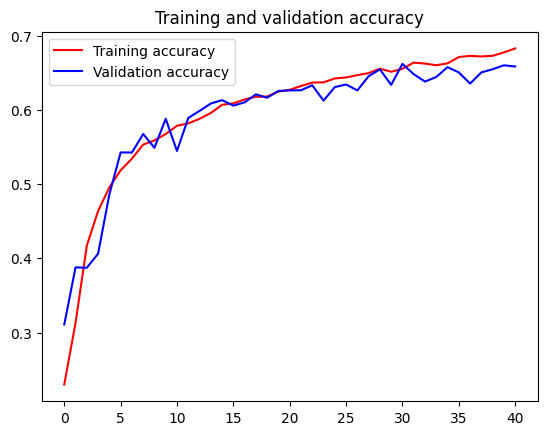

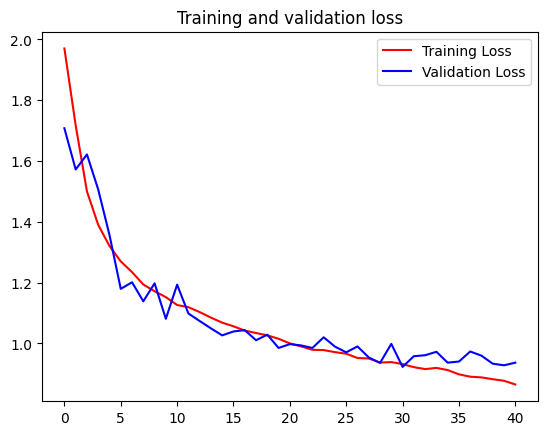

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    "split-folders/test/",
    target_size=(48,48),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

accuracy_score = model.evaluate(test_generator)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

Found 1416 images belonging to 7 classes.
23/23 [==============================] - 1s 44ms/step - loss: 0.9374 - accuracy: 0.6427
Accuracy: 64.2655%
Loss:  0.9373759627342224


In [29]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.15      0.14      0.14       192
     disgust       0.04      0.04      0.04        23
        fear       0.16      0.12      0.14       204
       happy       0.28      0.30      0.29       365
     neutral       0.16      0.20      0.18       244
         sad       0.15      0.13      0.14       228
    surprise       0.09      0.10      0.10       160

    accuracy                           0.18      1416
   macro avg       0.15      0.15      0.15      1416
weighted avg       0.18      0.18      0.18      1416



2/2 [==============================] - 3s 8ms/step


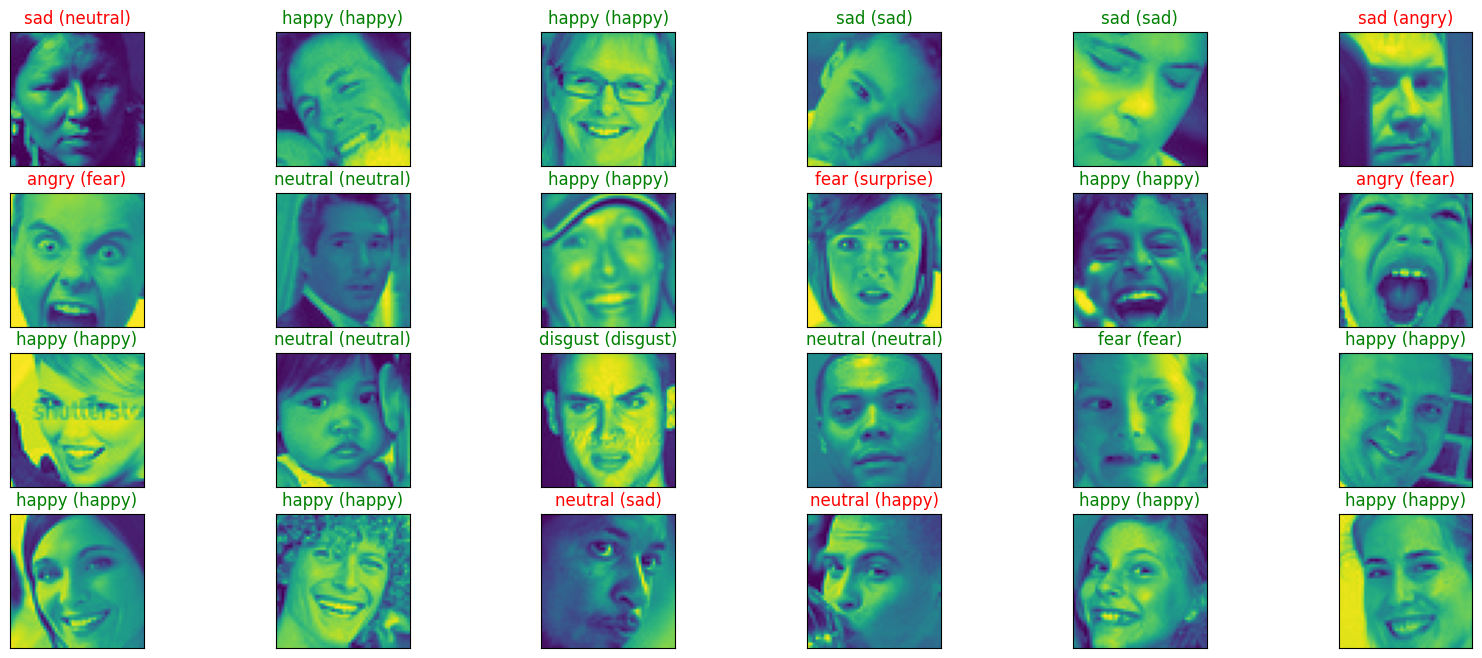

In [20]:
x_test,y_test = next(test_generator)
predict = model.predict(x_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))
